In [1]:
import sys
%matplotlib widget
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

In [2]:
import lightkurve as lk

search_result = lk.search_lightcurve("TOI-540", author="SPOC", exptime=120)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,200322593,0.0
1,TESS Sector 05,2018,SPOC,120,200322593,0.0
2,TESS Sector 06,2018,SPOC,120,200322593,0.0
3,TESS Sector 31,2020,SPOC,120,200322593,0.0
4,TESS Sector 32,2020,SPOC,120,200322593,0.0


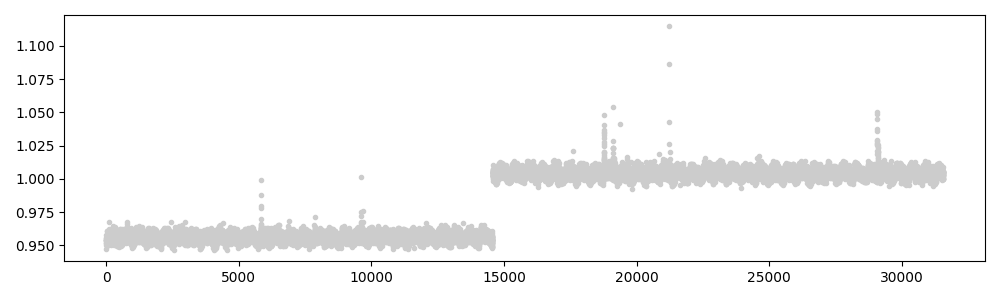

In [3]:
# data
klc = [search_result[i].download() for i in [0, 1]]
times = [k.time.to_value('mjd') for k in klc]
fluxes = [k.pdcsap_flux.to_value().filled(np.nan) for k in klc]
errors = [k.flux_err.to_value().filled(np.nan) for k in klc]
masks = [np.isnan(f) | np.isnan(e) | np.isnan(t) for f, e, t in zip(fluxes, errors, times)]
times = [t[~m] for t, m in zip(times, masks)]

# masking
time = np.hstack(times)
original_flux = np.hstack([f[~m] for f, m in zip(fluxes, masks)])
original_error = np.hstack([e[~m] for e, m in zip(errors, masks)])

# norm
flux_median = np.median(original_flux)
flux =  original_flux / flux_median
error = original_error / flux_median

plt.figure(None, (10, 3))
plt.plot(flux, ".", c="0.8")
plt.tight_layout()

In [4]:
from scipy.linalg import block_diag

X = block_diag(*[(t**np.arange(0, 3)[:, None]).T for t in times]).T
X[1::] -= X[1::].mean(1)[:, None]
X[1::] /= X[1::].std(1)[:, None]

In [205]:
from tinygp import kernels
import jax
import jaxopt
import numpy as np
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)

def plot_kernel(kernel, lag=None, **kwargs):
    if lag is None:
        lag = np.linspace(0, 30, 1000)
    k = kernel(lag, lag[:1])
    plt.plot(lag, k/k[0], **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")
    
def print_params(params):
    return {n.split("log_")[-1] if "log" in n else n: f"{np.exp(p):.2e}" if "log" in n else p for n, p in params.items()}

# GP
def build_gp(params, x):
    
    periodic = kernels.quasisep.SHO(omega=jnp.exp(params["log_omega"]), quality=jnp.exp(params["log_quality"]), sigma=jnp.exp(params["log_sigma"]))
    
    kernel = periodic
    
    return GaussianProcess(kernel, x, diag=jnp.exp(2 * params["log_jitter"]), mean=0.)

@jax.jit
def solve(x, y, X, solver):
    Liy = solver.solve_triangular(y)
    LiX = solver.solve_triangular(X.T)
    LiXT = LiX.T
    LiX2 = LiXT@LiX
    w = jax.numpy.linalg.lstsq(LiX2, LiXT@Liy)[0]
    v = jnp.linalg.inv(LiX2)
    return w, v

@jax.jit
def neg_log_likelihood(params, x, y, X):
    gp = build_gp(params, x)
    w = solve(x, y, X, gp.solver)[0]
    return - gp.log_probability(y - w@X)

@jax.jit
def _eval(params, x, y, X):
    gp = build_gp(params, x)
    w, v = solve(x, y, X, gp.solver)
    return - gp.log_probability(y - w@X), w, v
    
def model(x, y, X, mask=None):
    if mask is None:
        mask = mask = np.ones_like(x).astype(bool)
        
    masked_x = x[mask]
    masked_y = y[mask]
    masked_X = X[:, mask]
    
    @jax.jit
    def mu(params):
        gp = build_gp(params, masked_x)
        w = solve(masked_x, masked_y, masked_X, gp.solver)[0]
        cond_gp = gp.condition(masked_y - w@masked_X, x).gp
        return cond_gp.loc + w@X
    
    def optimize(init_params, param_names=None):
        def inner(theta, *args, **kwargs):
            params = dict(init_params, **theta)
            return neg_log_likelihood(params, *args, **kwargs)

        param_names = list(init_params.keys()) if param_names is None else param_names
        start = {k: init_params[k] for k in param_names}

        solver = jaxopt.ScipyMinimize(fun=inner)
        soln = solver.run(start, x=masked_x, y=masked_y, X=masked_X)
        print(soln.state)

        return dict(init_params, **soln.params)
    
    def plot_kernel(params, lag=None, **kwargs):
        gp = build_gp(params, masked_x)
        if lag is None:
            lag = np.linspace(0, 30, 1000)
        k = gp.kernel(lag, lag[:1])
        plt.plot(lag, k/k[0], **kwargs)
        plt.xlabel("dx")
        plt.ylabel("k(dx)")
    
    return optimize, mu, plot_kernel


def iterative_opt(params, model, x, y, X, it=3, upper_sigma=4, lower_sigma=3, n_up=15):
    
    mask = np.ones_like(x).astype(bool)

    new_params = params.copy()

    for i in range(it):
        if i == 0:
            m = np.mean(flux)
        else:
            m = mu(new_params).__array__()
        r = (flux - m)
        mask_up = r < np.std(r[mask])*upper_sigma
        mask_down = r > - np.std(r[mask])*lower_sigma

        # mask around flares
        ups = np.flatnonzero(~mask_up)
        if len(ups) > 0:
            mask_up[np.hstack([np.arange(max(u-n_up, 0), min(u+n_up, len(time))) for u in ups])] = False
        mask = np.logical_and(mask_up, mask_down)

        optimize, mu, plot_kernel = model(x, y, X, mask=mask)
        new_params = optimize(new_params)
    
    return new_params

In [206]:
optimize, mu, plot_kernel = model(time, flux, X)

In [207]:
period = 17/24

import jax.numpy as jnp

init_params = {
    "log_omega": jnp.log(2 * jnp.pi / period),
    "log_quality": jnp.log(30),
    "log_sigma": jnp.log(5e-1),
    "log_jitter": jnp.log(np.mean(error)),
}

new_params = init_params
new_params = optimize(new_params, ["log_sigma"])
new_params = optimize(new_params, ["log_quality", "log_jitter"])
new_params = optimize(new_params, ["log_quality", "log_jitter", "log_sigma"])

ScipyMinimizeInfo(fun_val=DeviceArray(-140844.08640176, dtype=float64, weak_type=True), success=True, status=0, iter_num=7)
ScipyMinimizeInfo(fun_val=DeviceArray(-141232.08621527, dtype=float64, weak_type=True), success=False, status=2, iter_num=8)
ScipyMinimizeInfo(fun_val=DeviceArray(-141873.0415596, dtype=float64, weak_type=True), success=False, status=2, iter_num=9)


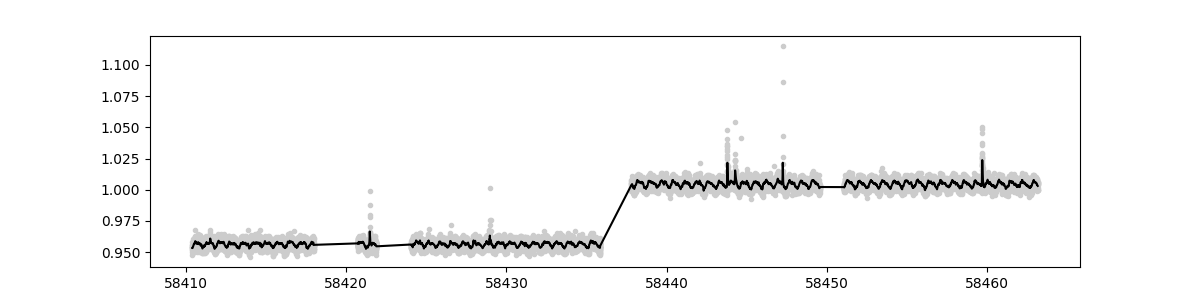

In [208]:
plt.figure(None, (12, 3))
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, mu(new_params), c="k")

In [209]:
{p.replace("log_", ""): np.exp(v) for p, v in new_params.items()}

{'omega': 8.87037925719471,
 'quality': 0.018293099867867566,
 'sigma': 0.01678591968956381,
 'jitter': 0.002524194}

In [211]:
amp = np.exp(new_params["log_sigma"])

In [212]:
# amplitude
sigma = np.exp(new_params["log_sigma"])
depths = 2*sigma/np.array([15., .1])
print(f"depth: {2*sigma/15:.5f} - {2*sigma/0.1:.5f}")
# duration
omega = np.exp(new_params["log_omega"])
print(f"duration: {np.pi/(omega*10):.5f} - {np.pi/(omega*1):.5f}")

depth: 0.00224 - 0.33572
duration: 0.03542 - 0.35417


In [215]:
import astropy.constants as c
import astropy.units as u

# TOI-540
# https://exofop.ipac.caltech.edu/tess/target.php?id=200322593
Rs = 0.178 * u.R_sun
Ms = 0.157 * u.M_sun
w = np.exp(new_params["log_jitter"])
duration = (np.max(time) - np.min(time)) * u.day
dt = 2 * u.minute

def taudelta_to_RP(tau_v, delta_v, sigma, omega):
    depth = 2*sigma/delta_v
    Rp = np.sqrt(depth)*Rs
    #
    T = ((np.pi/(omega*tau_v))*u.day).to(u.hour)
    a = (T/13)**2 * (Ms/u.M_sun) * (u.R_sun/Rs)**2 * (1/u.hour)**2 * c.au
    P = 2*np.pi*a**(3/2) / np.sqrt(c.G * Ms)
    P = P.decompose().to(u.day)
    
    n_tr = (duration/P).decompose()
    snr = (depth/w)*np.sqrt(n_tr*(T/dt).decompose())
    
    return Rp, P.decompose().to(u.day), snr

In [235]:
duration

<Quantity 50.80164756 d>

In [230]:
duration = np.sum([(np.max(t) - np.min(t)) for t in times]) * u.day
Rp, P, snr = taudelta_to_RP(7, 8, sigma, omega)
print(snr, P)

24.844887764821834 8.286491183100438 d


In [117]:
(a/Rs).decompose(), (Rp/Rs)**2

(<Quantity 102.36563677>, <Quantity 0.00412612>)

In [115]:
(Rp/Rs)**2

<Quantity 0.00412612>

In [74]:
Rp.to(u.R_earth), (a/Rs).to(u.R_sun)

UnitConversionError: '' (dimensionless) and 'solRad' (length) are not convertible

In [67]:
c.au

<<class 'astropy.constants.iau2015.IAU2015'> name='Astronomical Unit' value=149597870700.0 uncertainty=0.0 unit='m' reference='IAU 2012 Resolution B2'>

In [66]:
u.h

Unit("h")

In [ ]:
tau = 1
